In [42]:
%matplotlib inline

# Reconstructing trees from ultrametric distances

In [51]:
'''
This module presents an algorithm for reconstructing
the ultrametric tree corresponding to a matrix of 
ultrametric distances. 

The algorithm is the one presented by Dan Gusfield in:

    http://web.cs.ucdavis.edu/~gusfield/ultraerrat/ultraerrat.html
    
Additional information can be found on his book:

    Algorithms on Strings, Trees, and Sequences.


Usage:

```python
# An ultrametric matrix
>>> ultrametric = [ [0, 8, 8, 5, 3],
                    [8, 0, 3, 8, 8],
                    [8, 3, 0, 8, 8],
                    [5, 8, 8, 0, 5],
                    [3, 8, 8, 5, 0] ]
>>> nodes = ['A', 'B', 'C', 'D', 'E']

# Get the tree
>>> t = ultrametric_tree(ultrametric, nodes)
>>> print(t)

             /-A
          /-|
       /-|   \-E
      |  |
    --|   \-D
      |
      |   /-B
       \-|
          \-C
```
    

Algorithm description:

    "...here is another combinatorial algorithm that I claim is correct 
     and that does run in O(n^2) time. The algorithm is described in terms 
     of a graph G, based on matrix D, but it can be implemented without an 
     explicit graph.

     Let each row i of matrix D be represented by a node i in G, and each 
     edge (i,j) be given the value D(i,j). In O(n2) time, the algorithm 
     will find a very particular path in graph G:

        Set N equal to all the indices 1 through n; set L to the empty path; 
        set i to any node.

        Repeat n-1 times: begin remove i from N; find an index j in N such 
        that D(i,j) <= D(i,k) for any k in N. place edge (i,j) in the path L; 
        set i to j; end;

     What this produces is a path L of exactly n edges, and the algorithm 
     can be implemented in O(n2) time. It turns out that L is a minimum 
     spanning tree of G, but that fact is not needed.

     We will now use L to create the ultrametric tree recursively.

     Concentrate on an edge (p,q) in the path L with the largest edge weight 
     of all edges in L, and let P be the set of nodes at or to the left of p 
     in L, and let Q be the set of nodes at or to the right of q in L. The 
     fact that D is an ultrametric matrix implies that for any pair of nodes 
     (i,j) where i is in P and j is in Q, D(i,j) = D(p,q). One way to prove 
     this is by induction on the number of edges between i and j in L 
     (applying the ultrametric condition that in any triangle, the max of the 
     three edge weights is not unique). What this means is that in the 
     ultrametric tree we are building (and in any ultrametric tree for D), 
     any pair of leaves (i,j) where i is in P and j is in Q must have their 
     least common ancestor at the root of the ultrametric tree, and that root 
     must be labelled D(p,q).

     If there are k > 1 ties for the global max edge weight in L, then 
     removing those k edges creates k+1 subpaths of nodes, and applying the 
     above argument, any two nodes i and j which are in different subpaths 
     must have their least common ancestor at the root of the tree, which 
     again must be labeled D(p,q). Hence, any ultrametric tree T for D must 
     have exactly k+1 edges out of D, and the leaf set below any such edge 
     must be exactly the (distinct) set of nodes in one of the k+1 subpaths.

     No matter what k is, removing the k max weight edges in L, and 
     partitioning N, takes only O(n) time.

     To continue the description of the algorithm, we assume for convenience 
     that k = 1. Let LP and LQ denote the two subpaths created by removing 
     the max weight edge in L. Now we want to find an ultrametric tree for 
     set P and one for set Q; these two ultrametric trees will then be 
     attached to the root to creat the full ultrametric tree for D. But note 
     that we already have the needed paths LP and LQ that would be created if 
     we were to recursively apply the above method (clearly LP could result 
     if we applied the path building algorithm to P alone, and similarly for 
     LQ and Q). So we only need to find the max weight edge(s) in LP and the 
     max weight edge(s) in LQ. Those two edges can be found in O(n) total 
     time. Again, because the nodes were partitioned in the first step, this 
     time bound holds even for k > 1.

     Continuing, we build the ultrametric tree in O(n2) total time.

     Note that at each step of the algorithm, the node partitions that are 
     created, and the associated edges that are put into T, are forced. Hence 
     if D is an ultrametric matrix, the ultrametric tree T for D is unique.
    " - Dan Gusfield.

'''

import networkx as nx
import ete3 as ete


def ultrametric_tree(ultrametric, nodes):
    g = get_graph(ultrametric, nodes)
    P = get_path(g, ultrametric, nodes)
    t = path_to_tree(P)
    t.standardize()
    
    return t
# ---


def get_graph(ultrametric, nodes):
    "From an ultrametric matrix, get the weights graph."
    
    n = len(nodes) # Matrix dimensions
    g = nx.Graph()
    
    # Add nodes
    g.add_nodes_from(nodes)
    
    # Add edge weights
    for i in range(n):
        for j in range(i+1, n):
            g.add_edge(nodes[i], nodes[j], weight=ultrametric[i][j])
            
    return g
# ---

def get_path(g, ultrametric, nodes):
    "From the weights graph, get the path."
    weight = weights_for(ultrametric, nodes)
    
    N = set(nodes)
    L = nx.Graph()
    i = N.pop()

    while(N):
        # Find a node j in N for which D(i,j) is max
        j,w = min([(node, weight(i, node)) for node in N],
                  key=(lambda x:x[-1]))
        # Place (i,j) in path L
        L.add_edge(i,j, weight=w)
        
        i = j
        N.remove(j)
        
    return L
# ---

def path_to_tree(P):    
    tree = ete.Tree()
    
    if len(P.edges) <= 1:
        # Edge case
        for v in P.nodes:
            tree.add_child(name=v)
    else:
        # Remove the edge with the maximum weight
        P = P.copy()
        edge, weight = max_edge_weight(P)
        P.remove_edge(*edge)
        
        # Do the same to the remaining subpaths
        for c in nx.connected_components(P):
            component = P.subgraph(c).copy()
            tree.add_child(path_to_tree(component))
            
    return tree
# ---

def weights_for(matrix, nodes):
    "Get the entries by node name."
    # Translate node names to indices
    to_indices = {node:i for i,node in enumerate(nodes)}
    
    def weight_fn(a,b):
        return matrix[to_indices[a]][to_indices[b]]
    
    return weight_fn
# ---

def max_edge_weight(L):
    "Return the edge with the largest weight."
    return max([(edge,weight) for *edge,weight in L.edges.data('weight')],
               key=lambda x: x[-1])
# ---

def draw_graph(g):
    "Display an edge-weighted graph."
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx_edge_labels(g,
                                 nx.circular_layout(g),
                                 edge_labels=labels)
    nx.draw_circular(g, with_labels=True)
# ---

In [52]:
# An ultrametric matrix
ultrametric = [ [0, 8, 8, 5, 3],
                [8, 0, 3, 8, 8],
                [8, 3, 0, 8, 8],
                [5, 8, 8, 0, 5],
                [3, 8, 8, 5, 0] ]
nodes = ['A', 'B', 'C', 'D', 'E']

# Get the tree
t = ultrametric_tree(ultrametric, nodes)
print(t)

    #         /-A
    #      /-|
    #   /-|   \-E
    #  |  |
    #--|   \-D
    #  |
    #  |   /-B
    #   \-|
    #      \-C


      /-C
   /-|
  |   \-B
--|
  |      /-A
  |   /-|
   \-|   \-E
     |
      \-D


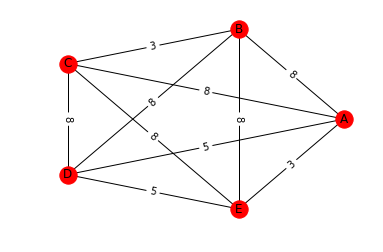

In [53]:
g = get_graph(ultrametric, nodes)
draw_graph(g)

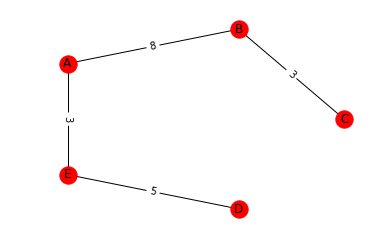

In [54]:
P = get_path(g, ultrametric, nodes)
draw_graph(P)

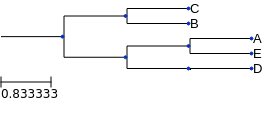

In [55]:
t = path_to_tree(P)
t.render('%%inline')

# The Cavender-Farris-Neyman model

In [314]:
#%%writefile cellsystem/reconstruction/cfn_model.py 
"""
Module implementing the Cavender-Farris-Neymann stochastic tree model.

The model is based on the description by the book:
    
    Computational Phylogenetics.
      An introduction to designing methods for phylogeny estimation.
      -- by Tandy Warnow
      
Usage:

```python
# Create a new empty tree.
>>> cfn = CFN_Tree()

# Branch randomly until you have 5 leaves.
>>> cfn.populate(5)

     Node: 0, node probability: 0
     Node: 1, node probability: 0.2192846999188683
     Node: 2, node probability: 0.06144844447962278
     Node: 3, node probability: 0.14342505932071808
     Node: 4, node probability: 0.1370117188846906
     Node: 5, node probability: 0.44060196062669255
     Node: 6, node probability: 0.009555798385131098
     Node: 7, node probability: 0.48946332859444935
     Node: 8, node probability: 0.39505550345399304
    
           /-3
        /1|
       |  |   /-7
       |   \4|
     -0|      \-8
       |
       |   /-5
        \2|
           \-6

# Evolve 5 traits through the tree
>>> sequences = cfn.evolve_traits([1,1,1,1,1])
>>> sequences

     { 3: [0, 0, 0, 1, 1], 
       7: [1, 0, 1, 0, 1], 
       8: [1, 0, 0, 1, 1], 
       5: [1, 1, 1, 1, 1], 
       6: [1, 1, 1, 1, 1] }


```

The CFN model in words from the book:

"The Cavender-Farris-Neyman (CFN) model describes how a trait (which 
 can either be present or absent) evolves down a tree (Cavender, 
 1978; Farris, 1973; Neyman, 1971).

 ...a CFN model has a rooted binary tree T (i.e., a tree in which 
 every node is either a leaf or has two children) with numerical 
 parameters that describe the evolutionary process of a trait. Under 
 the CFN model, the probability of absence (0) or presence (1) is the 
 same at the root, but the state can change on the edges (also called 
 branches) of the tree. Thus, we associate a parameter p(e) to every 
 edge e in the tree, where p(e) denotes the probability that the 
 endpoints of the edge e have different states. In other words, p(e)
 is the probability of changing state (from 1 to 0, or vice-versa)
 ... we require 0 < p(e) < 0.5.

 Under  the  CFN  model,  a  trait  (which  is  also  called  a  
 “character”)  evolves  down  the tree under this random process, and 
 hence attains a state at every node in the tree, and in particular 
 at the leaves of the tree. You could write a computer program for a 
 CFN model tree that would generate 0s and 1s at the leaves of the 
 tree; thus, CFN is a generative model.
 
 Each time you ran the program you would get another pattern of 0s and 
 1s at the leaves of the tree. Thus, if you repeated the process 10 
 times, each time independently generating a new trait down the tree, 
 you would produce sequences of length 10 at the leaves of the tree."
    -- from the book.
"""

import math
import ete3 as ete
import random as rnd
from collections import defaultdict


def poisson_expected_value(probability):
    "Return the expected value of a poisson random variable."
    return -math.log(1 - 2*probability) / 2
# ---

def swap(binary):
    if binary:
        return 0
    else:
        return 1
# ---

def random_test(probability):
    'Return True with a given probability, otherwise return False.'
    return (rnd.random() < probability)
# ---


class CFN_Tree(ete.Tree):
    "A Cavender-Farris-Neymann stochastic tree model."
    
    def populate(self, n):
        'Populate the tree with nodes and change probabilities.'
        # Populate the usual way
        super().populate(n)
        # Change names and add probabilities
        for i,node in enumerate(self.traverse()):
            node.name = i
            if i > 0:
                # Add a change probability < 0.5
                p = rnd.random() / 2
                node.add_feature('probability', p)
                # The probability must be associated to the edge (branch),
                # in this implementation, we associate the probability to
                # the node downstream of the edge.
                
                # Add the distance from the previous node 
                node.dist = poisson_expected_value(p)
                # The 'CNF model distance' is the expected number of
                # changes in traversing the edge, modeled as a Poisson rv.
                
                print(f"Node: {i}, node probability: {node.probability}, branch length: {node.dist}")
            else:
                # No probability of change before this
                node.add_feature('probability', 0)
            
        print(self)
    # ---        
        
    def total_nodes(self):
        return len(list(self.traverse()))
    # ---
    
    def evolve_traits(self, traits):
        "Evolve the binary traits through the tree."
        # The sequences generated
        sequences = defaultdict(list)
        for leaf in self.iter_leaves():
            path_from_root = list(reversed(leaf.get_ancestors()))
            path_from_root.append(leaf)
            # Evolve each trait
            for trait in traits:
                # Follow path stochastically 
                final_trait = self.trait_traverse(path_from_root, trait)
                # Save character's final state
                sequences[leaf.name].append(final_trait)
        return dict(sequences)
    # ---
            
    def trait_traverse(self, path_from_root, init):
        # Follow path stochastically 
        trait = init
        for node in path_from_root: 
            probability = node.probability
            if random_test(probability):
                trait = swap(trait)
        # Return character's final state
        return trait
    # ---
    
    def __str__(self):
        return self.get_ascii(show_internal=True)
    # ---
# --- CFN_Tree

Node: 1, node probability: 0.14320389502973357, branch length: 0.16872180716953908
Node: 2, node probability: 0.19946946595212833, branch length: 0.2545293694003664
Node: 3, node probability: 0.044762741760365654, branch length: 0.04689468434840173
Node: 4, node probability: 0.32444491067342357, branch length: 0.5233276027378082
Node: 5, node probability: 0.273760084278192, branch length: 0.396506044115407
Node: 6, node probability: 0.3481427566383571, branch length: 0.595833603649967
Node: 7, node probability: 0.4464929691439005, branch length: 1.1173975176418922
Node: 8, node probability: 0.16226189967547766, branch length: 0.19616867720116893

   /-1
-0|
  |   /-3
   \2|
     |   /-5
      \4|
        |   /-7
         \6|
            \-8


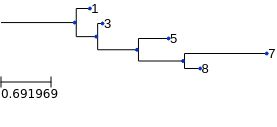

In [344]:
# Create a new empty tree.
cfn = CFN_Tree()

# Branch randomly until you have 5 leaves.
cfn.populate(5)

    # Node: 0, node probability: 0
    # Node: 1, node probability: 0.2192846999188683
    # Node: 2, node probability: 0.06144844447962278
    # Node: 3, node probability: 0.14342505932071808
    # Node: 4, node probability: 0.1370117188846906
    # Node: 5, node probability: 0.44060196062669255
    # Node: 6, node probability: 0.009555798385131098
    # Node: 7, node probability: 0.48946332859444935
    # Node: 8, node probability: 0.39505550345399304
    #
    #       /-3
    #    /1|
    #   |  |   /-7
    #   |   \4|
    # -0|      \-8
    #   |
    #   |   /-5
    #    \2|
    #       \-6
    
cfn.render('%%inline')

In [345]:
# Evolve 5 traits through the tree
sequences = cfn.evolve_traits([1,1,1,1,1])
print(sequences)

    # { 3: [0, 0, 0, 1, 1], 
    #   7: [1, 0, 1, 0, 1], 
    #   8: [1, 0, 0, 1, 1], 
    #   5: [1, 1, 1, 1, 1], 
    #   6: [1, 1, 1, 1, 1] }

{1: [0, 0, 1, 0, 1], 3: [1, 1, 1, 1, 0], 5: [0, 1, 0, 1, 0], 7: [1, 1, 1, 0, 0], 8: [0, 0, 1, 1, 1]}


## Clocklike reconstruction on the CFN model

In [346]:
# Evolve traits through the tree
sequences = cfn.evolve_traits([1]*10000)

In [347]:
def simpledistance(seq_1, seq_2):
    "From two binary sequences, compute their distance."
    differences = (1 for a,b in zip(seq_1, seq_2) if a != b)
    return sum(differences)
# ---

binary_distance([0]*10, [1]*4 + [0]*6)

4

In [348]:
import itertools as it

def pairwise_distances(sequences, distance_fn=simpledistance):
    "From the binary sequences, compute pairwise edit distances."
    # Get all the pairs
    pairs = it.combinations(sequences, 2)
    # Compute distances
    distances = dict()
    for i,j in pairs:
        distances[(i,j)] = distance_fn(sequences[i], sequences[j])
    return distances
# ---

pairwise_distances(sequences)

{(1, 3): 2985,
 (1, 5): 4648,
 (1, 7): 4938,
 (1, 8): 4842,
 (3, 5): 4671,
 (3, 7): 4989,
 (3, 8): 4953,
 (5, 7): 5036,
 (5, 8): 5004,
 (7, 8): 5026}

In [349]:
leaves = list(sequences.keys())
leaves

[1, 3, 5, 7, 8]

In [350]:
###
### Not cleaned up.
###

import ete3 as ete

def make_cherry_of(a,b):
    "Get a cherry tree out of both items."
    cherry = ete.Tree()
    cherry.add_child(name=a)
    cherry.add_child(name=b)
    return cherry
# ---

def infer_clocklike_tree_from(sequences):
    "Assume the sequences evolved in a clocklike CFN model, infer the tree."
    if len(sequences) == 2:
        # Return a cherry tree
        cherry = make_cherry_of(*sequences)
        return cherry
    else:
        # Find closest taxa in S
        distances = pairwise_distances(sequences)
        a,b = min(distances, key=lambda x: distances[x])
        print(a,b, distances[(a,b)])
        # Recurse on (sequences \ a)
        chopped = {k:v for k,v in sequences.items() if k != a}
        tree = infer_clocklike_tree_from(chopped)
        print(f"Tree before a={a},b={b} {distances[(a,b)]}: \n{tree}")
        # Find the node corresponding to b and as a as sibling
        b_node = tree.search_nodes(name=b)[0]
        b_parent = b_node.up
        # Detach from the parent
        b_node.detach()
        # Make a new cherry out of a and b
        # and attach it in place of b
        cherry = make_cherry_of(a,b)
        b_parent.add_child(cherry)
        print(f"Tree after a={a},b={b} {distances[(a,b)]}: \n{tree}")
        return tree
# ---

t = infer_clocklike_tree_from(sequences)
print(t)

1 3 2985
3 5 4671
5 8 5004
Tree before a=5,b=8 5004: 

   /-7
--|
   \-8
Tree after a=5,b=8 5004: 

   /-7
--|
  |   /-5
   \-|
      \-8
Tree before a=3,b=5 4671: 

   /-7
--|
  |   /-5
   \-|
      \-8
Tree after a=3,b=5 4671: 

   /-7
--|
  |   /-8
   \-|
     |   /-3
      \-|
         \-5
Tree before a=1,b=3 2985: 

   /-7
--|
  |   /-8
   \-|
     |   /-3
      \-|
         \-5
Tree after a=1,b=3 2985: 

   /-7
--|
  |   /-8
   \-|
     |   /-5
      \-|
        |   /-1
         \-|
            \-3

   /-7
--|
  |   /-8
   \-|
     |   /-5
      \-|
        |   /-1
         \-|
            \-3


In [351]:
"""
"An assumption that is sometimes made is that sequence 
evolution is clocklike (also referred to as obeying 
the strict molecular clock), which means that the 
expected number of changes is proportional to time. 
If we assume that the leaves represent extant (i.e., 
living) species, then under the assumption of a 
strict molecular clock, the total expected number of 
changes from the root to any leaf is the same. Under 
the assumption of a strict molecular clock, the matrix 
of expected distances between the leaves in the tree 
has properties that make it “ultrametric”."

    -- From the book.
"""

import ete3 as ete

def make_cherry_of(a,b):
    "Get a cherry tree out of both items."
    cherry = ete.Tree()
    cherry.add_child(name=a)
    cherry.add_child(name=b)
    return cherry
# ---

def infer_clocklike_tree_from(sequences):
    "Assume the sequences evolved in a clocklike CFN model, infer the tree."
    if len(sequences) == 2:
        # Return a cherry tree
        cherry = make_cherry_of(*sequences)
        return cherry
    else:
        # Find closest taxa in S
        distances = pairwise_distances(sequences, binary_distance)
        a,b = min(distances, key=lambda x: distances[x])
        # Recurse on (sequences \ a)
        chopped = {k:v for k,v in sequences.items() if k != a}
        tree = infer_clocklike_tree_from(chopped)
        # Find the node corresponding to b and add a as sibling
        b_node = tree.search_nodes(name=b)[0]
        b_parent = b_node.up
        # Detach from the parent
        b_node.detach()
        # Make a new cherry out of a and b
        # and attach it in place of b
        cherry = make_cherry_of(a,b)
        b_parent.add_child(cherry)
        return tree
# ---

t = infer_clocklike_tree_from(sequences)
print(t)


   /-7
--|
  |   /-8
   \-|
     |   /-5
      \-|
        |   /-1
         \-|
            \-3


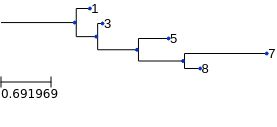

In [352]:
cfn.render('%%inline')

## Application: Clocklike reconstruction in a cell system

In [357]:
from cellsystem import *

# The cell system will simulate cell growth
# while tracking the steps in that process.
system = CellSystem(grid_dimensions=(10, 10))

# Initialize the first cell
# in the middle of the grid
system.seed()


# Take 20 steps forward in time
system.run(steps=17)

New cell 0 added @ (5, 5)
Cell no. 0 mutating @ site (5, 5) (father None)
		 Initial mutations: []
                	 Initial genome: AAAAAAAAAA
		 Final mutations: [(7, 'T')]
                	 Final genome: AAAAAAATAA
Cell no. 0 migrating from site (5, 5) (father None)
	 New site: (4, 6)
Cell no. 0 migrating from site (4, 6) (father None)
	 New site: (3, 6)
Cell no. 0 mutating @ site (3, 6) (father None)
		 Initial mutations: [(7, 'T')]
                	 Initial genome: AAAAAAATAA
		 Final mutations: [(7, 'T'), (2, 'T')]
                	 Final genome: AATAAAATAA
Cell no. 0 dividing @ (3, 6)
	New cells: 2 @ (2, 7) and 1 @ (4, 7)
Cell no. 1 migrating from site (4, 7) (father None)
	 New site: (5, 6)
Cell no. 2 mutating @ site (2, 7) (father 0)
		 Initial mutations: [(7, 'T'), (2, 'T')]
                	 Initial genome: AATAAAATAA
		 Final mutations: [(7, 'T'), (2, 'T'), (9, 'T')]
                	 Final genome: AATAAAATAT
Cell no. 1 mutating @ site (5, 6) (father None)
		 Initial mutati

In [358]:
# Fetch the evolved DNA sequences
cell_sequences = {cell.index:cell.genome for cell in system['cells'].alive_cells}
cell_sequences

{9: 'CATAAAATAA',
 10: 'CATAATAGAT',
 13: 'CATAAAACAT',
 15: 'CATAAAACAT',
 17: 'CATAAAACAT',
 18: 'CATAAAACAT',
 19: 'CATAAAACAT',
 20: 'CATAAAACAT'}

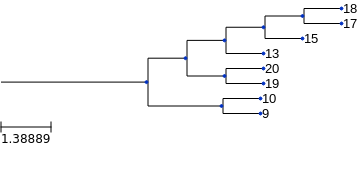

In [359]:
# Look at the real ancestry tree
t = system['log'].ancestry(prune_death=True)
t.show(inline=True)

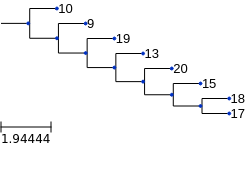

In [360]:
t = infer_clocklike_tree_from(cell_sequences)
t.render('%%inline')

## Estimating the unrooted CFN tree when evolution is not clocklike

Node: 1, node probability: 0.48807580134661316, branch length: 1.868019131391573
Node: 2, node probability: 0.30118123884176534, branch length: 0.46110721831458207
Node: 3, node probability: 0.10850989232047781, branch length: 0.12232392552562638
Node: 4, node probability: 0.2310106089620788, branch length: 0.3099680790594053
Node: 5, node probability: 0.3695614563382853, branch length: 0.6718529561884975
Node: 6, node probability: 0.3645150518116225, branch length: 0.652873773876636
Node: 7, node probability: 0.43372809120715405, branch length: 1.010420994732352
Node: 8, node probability: 0.27433765954621414, branch length: 0.39778414258609557

         /-7
      /3|
   /1|   \-8
  |  |
-0|   \-4
  |
  |   /-5
   \2|
      \-6


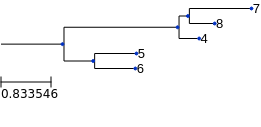

In [366]:
# Create a new empty tree.
cfn = CFN_Tree()

# Branch randomly until you have 5 leaves.
cfn.populate(5)
cfn.render('%%inline')

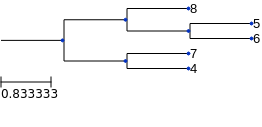

In [367]:
sequences = cfn.evolve_traits([1]*1000)
t = infer_clocklike_tree_from(sequences)
t.render('%%inline')

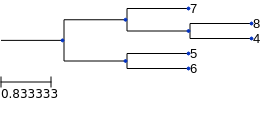

In [368]:
sequences = cfn.evolve_traits([1]*100_000)
t = infer_clocklike_tree_from(sequences)
t.render('%%inline')

It can be noted that assumming clocklike evolution converges to a tree whose distances look close to the CNF distances, but with the wrong topology.

In [369]:
import itertools as itr
import numpy as np

def get_leaf_distances(cfn_tree):
    "Get the CFN distances between each pair of leaves."
    # Fetch the tree's leaves
    leaves = cfn_tree.get_leaves()
    n = len(leaves)
    # Create an empty matrix
    distances = np.zeros((n,n))
    # Get all pairs of leaves
    pairs = itr.combinations(range(n), 2)
    # Fill the distance matrix
    for i,j in pairs:
        d = cfn_tree.get_distance(leaves[i],
                                  leaves[j])
        distances[i,j] = distances[j,i] = d 
        
    return distances
# ---
   
print([l.name for l in cfn.get_leaves()])
get_leaf_distances(cfn)

[7, 8, 4, 5, 6]


array([[ 0.        ,  1.40820514,  1.442713  ,  4.13372423,  4.11474504],
       [ 1.40820514,  0.        ,  0.83007615,  3.52108737,  3.50210819],
       [ 1.442713  ,  0.83007615,  0.        ,  3.31094738,  3.2919682 ],
       [ 4.13372423,  3.52108737,  3.31094738,  0.        ,  1.32472673],
       [ 4.11474504,  3.50210819,  3.2919682 ,  1.32472673,  0.        ]])

### The four point condition

The Four Point Condition is the statement that the two largest values of the three pairwise distance sums on four indices are the same. The Four Point Condition holds for any additive matrix, which allows branch lengths to be zero (as long as they are never negative)

In [370]:
_fpc_permutations = [(0,1,2,3),
                     (0,2,1,3),
                     (0,3,1,2)]

def fpc_sums(distances, quartet):
    "Return the sum corresponding to the relevant quartet."
    q = tuple(quartet)
    
    permutations = [ tuple(q[i] for i in p)
                        for p in _fpc_permutations ]
    
    # Calculate the relevant pairwise sums
    sums = { ((i,j), (k,l)): distances[i][j] + distances[k][l]
                for i,j,k,l in permutations }
    
    return sums
# ---
    

def is_additive(distances, tolerance=1e-4):
    """Is the distances matrix additive?
    
    Check the four point condition on each four indices of the matrix.
    """
    n = len(distances)
    quartets = list(itr.combinations(range(n), 4))
    
    for q in quartets:
        sums = list(fpc_sums(distances, q).values())
        # Now, we must verify that the largest one is repeated
        s_max = max(sums)
        if sum( (s_max-s)**2 < tolerance for s in sums) < 2:
            # It is only once
            return False
        
    return True
# ---   

distances = get_leaf_distances(cfn)

print(is_additive(distances))

distances[2][3] += 1
is_additive(distances)

True


False

### The four point method

In [371]:
# A test matrix to test the four-point method
additive = np.array([[0, 3,  6,  7],
                     [3, 0,  7,  6],
                     [6, 7,  0, 11],
                     [7, 6, 11,  0]])
leaves = ['L1', 'L2', 'L3', 'L4']

In [372]:
def induced_quartet(dist_matrix, items=None):
    """Get the induced quartet ordering of 4 items."""
    # Preprocess arguments
    if items is None:
        items = range(4) # The first 4 elements
    i = tuple(items)
    
    # Calculate the relevant pairwise sums
    sums = fpc_sums(dist_matrix, i)
    # Get the quartet with smallest sum
    quartet = min(sums, key=lambda x:sums[x])
    
    return quartet
# ---

def join_trees(a, b):
    "Make a 'cherry' of the two trees a and b."
    # Assemble the treee
    tree = Tree()
    tree.add_child(a)
    tree.add_child(b)
    
    return tree
# ---

def quartet_to_tree(quartet, names=None):
    "Transform the quartet structure to a tree."
    # Disassemble the quartet structure
    ((a,b),(c,d)) = quartet
    if names is None:
        names = { i:i for i in [a,b,c,d] }
    # Assemble the pairs of siblings
    ab_cherry = make_cherry_of(names[a],names[b])
    cd_cherry = make_cherry_of(names[c],names[d])
    # Assemble the subtrees
    quartet_tree = join_trees(ab_cherry, cd_cherry)
    
    return quartet_tree
# ---

def map_names_to_quartet(quartet, names=None):
    "Map the names to the quartet's indices."
    if names:
        ((a,b),(c,d)) = quartet

        return ((names[a],names[b]), (names[c],names[d]))
    else:
        return quartet
# ---

def four_point_method(additive, names=None):
    "Method for inferring a tree from a 4x4 additive matrix."
    # Calculate the quartet inferred by the distances
    quartet = induced_quartet(additive)
    # Assemble the quartet into a tree structure
    tree = quartet_to_tree(quartet, names)
    
    return tree
# ---

if is_additive(additive):
    print(f"The matrix: \n{additive} is additive.\n")
    
tree = four_point_method(additive, names=leaves)
print(f"The associated tree is: {tree}")

The matrix: 
[[ 0  3  6  7]
 [ 3  0  7  6]
 [ 6  7  0 11]
 [ 7  6 11  0]] is additive.

The associated tree is: 
      /-L1
   /-|
  |   \-L3
--|
  |   /-L2
   \-|
      \-L4


In [373]:
q = induced_quartet(additive)
map_names_to_quartet(q, leaves)

(('L1', 'L3'), ('L2', 'L4'))

### All quartets method

In [444]:
d = get_leaf_distances(cfn)
d, [l.name for l in cfn.get_leaves()]

(array([[ 0.        ,  1.40820514,  1.442713  ,  4.13372423,  4.11474504],
        [ 1.40820514,  0.        ,  0.83007615,  3.52108737,  3.50210819],
        [ 1.442713  ,  0.83007615,  0.        ,  3.31094738,  3.2919682 ],
        [ 4.13372423,  3.52108737,  3.31094738,  0.        ,  1.32472673],
        [ 4.11474504,  3.50210819,  3.2919682 ,  1.32472673,  0.        ]]),
 [7, 8, 4, 5, 6])

In [443]:
def all_quartets(dist_matrix, names=None):
    "Get all quartet subtrees."
    n = len(dist_matrix)
    quartets = itr.combinations(range(n), 4)
    
    return [map_names_to_quartet(induced_quartet(dist_matrix,q), 
                                 names)
             for q in quartets]
# ---

all_quartets(d, names=[l.name for l in cfn.get_leaves()])

[((7, 8), (4, 5)),
 ((7, 8), (4, 6)),
 ((7, 8), (5, 6)),
 ((7, 4), (5, 6)),
 ((8, 4), (5, 6))]

In [375]:
quartets = all_quartets(d, names=[l.name for l in cfn.get_leaves()])

def infer_siblings(quartets):
    """From the tree quartets, infer pairs of sibling leafs.
    
    We search for a pair x,y of leaves that is always 
    together in any quartet that contains both x and y. 
    (In other words, for all a,b, any quartet on {x ,y ,a ,b} 
    is ((x,y),(a,b))). Any pair of leaves that are siblings 
    in the quartets tree T will satisfy this property.
    """
    together = set()
    separated = set()
    
    for q in quartets:
        quartet = { frozenset(pair) for pair in q }

        together |= quartet

        ((a,b), (c,d)) = q
        separated |= { frozenset(i) 
                          for i in [(a,c), (a,d), 
                                    (b,c), (b,d)] }

    return [set(pair) for pair in together - separated]
# ---

infer_siblings(quartets)

[{5, 6}, {7, 8}]


      /-4
   /-|
  |  |   /-8
  |   \-|
--|      \-7
  |
  |   /-5
   \-|
      \-6


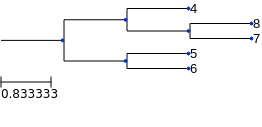

In [376]:
def add_as_sibling(a,b,tree):
    "Add leaf a as sibling of b in the given tree."
    # Find the node corresponding to b and add a as sibling
    b_node = tree.search_nodes(name=b)[0]
    b_parent = b_node.up
    # Detach from the parent
    b_node.detach()
    # Make a new cherry out of a and b
    # and attach it in place of b
    cherry = make_cherry_of(a,b)
    b_parent.add_child(cherry)
    return tree
# ---

def all_quartets_method(quartets):
    "From the given quartets, assemble the tree."
    if len(quartets) == 1:
        q = quartets[0]
        return quartet_to_tree(q)
    else:
        # Fetch a pair of sibling leafs
        a,b = list(infer_siblings(quartets).pop())
            
        new_quartets = [q for q in quartets if (a not in q[0]) and (a not in q[-1])]
        
        # Recourse in quartets \ {a}
        tree = all_quartets_method(new_quartets)
        # Add a as sibling of b
        tree = add_as_sibling(a,b,tree)
        return tree
        
print(all_quartets_method(quartets))
all_quartets_method(quartets).render('%%inline')

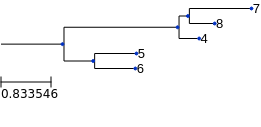

In [377]:
cfn.render('%%inline')

Looks good! Now, let's test how it performs with the distance matrix approximated from the sequences

In [424]:
def distance_matrix(sequences, distance_fn=simpledistance):
    "Calculate the distance matrix of the given sequences."
    n = len(sequences)
    d = pairwise_distances(sequences, distance_fn)
    
    # Transform to a matrix
    names = tuple(sequences.keys())
    to_indices = { names[i]:i for i in range(n) }
    mtx = np.zeros( (n,n) )
    for a,b in d:
        i,j = to_indices[a], to_indices[b]
        mtx[i,j] = mtx[j,i] = d[(a,b)]
    
    return mtx
# ---
k = 100_000 # Sequence length
sequences = cfn.evolve_traits([1]*k)
distances = distance_matrix(sequences)
distances

array([[     0.,  50397.,  49862.,  49808.,  50122.],
       [ 50397.,      0.,  50037.,  49995.,  49969.],
       [ 49862.,  50037.,      0.,  49806.,  49720.],
       [ 49808.,  49995.,  49806.,      0.,  49286.],
       [ 50122.,  49969.,  49720.,  49286.,      0.]])

In [425]:
is_additive(distances)

False

The inferred tree: 
      /-7
   /-|
  |   \-4
--|
  |   /-8
   \-|
     |   /-5
      \-|
         \-6


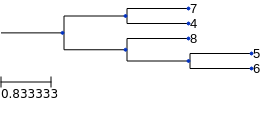

In [428]:
leaves = [l.name for l in cfn.get_leaves()]

quartets = all_quartets(distances, names=leaves)

tree = all_quartets_method(quartets)
print(f"The inferred tree: {tree}")
tree.render('%%inline')

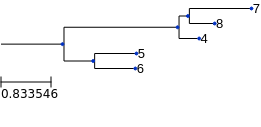

In [429]:
cfn.render('%%inline')

As we can see, the raw distances are a clocklike assumption of the real tree distances.

#### Treating the distances with the CFN distance correction

In [430]:
cfn_corrected = -np.log(1-2*distances/(1.1*k)) / 2

In [431]:
is_additive(cfn_corrected)

False

The inferred tree: 
      /-7
   /-|
  |   \-4
--|
  |   /-8
   \-|
     |   /-5
      \-|
         \-6


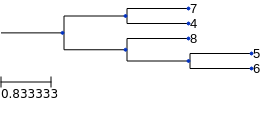

In [432]:
leaves = [l.name for l in cfn.get_leaves()]

quartets = all_quartets(cfn_corrected, names=leaves)

tree = all_quartets_method(quartets)
print(f"The inferred tree: {tree}")
tree.render('%%inline')

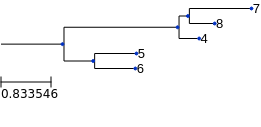

In [433]:
cfn.render('%%inline')

### Application to a cell system

In [434]:
print(cell_sequences)

m = distance_matrix(cell_sequences)    
m

{9: 'CATAAAATAA', 18: 'CATAAAACAT', 17: 'CATAAAACAT', 15: 'CATAAAACAT', 10: 'CATAATAGAT', 20: 'CATAAAACAT', 13: 'CATAAAACAT', 19: 'CATAAAACAT'}


array([[ 0.,  2.,  2.,  2.,  3.,  2.,  2.,  2.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  2.,  0.,  2.,  2.,  2.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.]])

In [435]:
is_additive(m)

True

In [436]:
cell_q = all_quartets(m, names=list(cell_sequences.keys()))
cell_q

[((9, 18), (17, 15)),
 ((9, 10), (18, 17)),
 ((9, 18), (17, 20)),
 ((9, 18), (17, 13)),
 ((9, 18), (17, 19)),
 ((9, 10), (18, 15)),
 ((9, 18), (15, 20)),
 ((9, 18), (15, 13)),
 ((9, 18), (15, 19)),
 ((9, 10), (18, 20)),
 ((9, 10), (18, 13)),
 ((9, 10), (18, 19)),
 ((9, 18), (20, 13)),
 ((9, 18), (20, 19)),
 ((9, 18), (13, 19)),
 ((9, 10), (17, 15)),
 ((9, 17), (15, 20)),
 ((9, 17), (15, 13)),
 ((9, 17), (15, 19)),
 ((9, 10), (17, 20)),
 ((9, 10), (17, 13)),
 ((9, 10), (17, 19)),
 ((9, 17), (20, 13)),
 ((9, 17), (20, 19)),
 ((9, 17), (13, 19)),
 ((9, 10), (15, 20)),
 ((9, 10), (15, 13)),
 ((9, 10), (15, 19)),
 ((9, 15), (20, 13)),
 ((9, 15), (20, 19)),
 ((9, 15), (13, 19)),
 ((9, 10), (20, 13)),
 ((9, 10), (20, 19)),
 ((9, 10), (13, 19)),
 ((9, 20), (13, 19)),
 ((18, 17), (15, 10)),
 ((18, 17), (15, 20)),
 ((18, 17), (15, 13)),
 ((18, 17), (15, 19)),
 ((18, 17), (10, 20)),
 ((18, 17), (10, 13)),
 ((18, 17), (10, 19)),
 ((18, 17), (20, 13)),
 ((18, 17), (20, 19)),
 ((18, 17), (13, 19)),


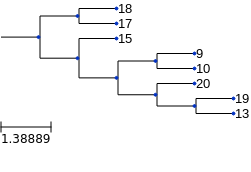

In [441]:
all_quartets_method(cell_q).render("%%inline")

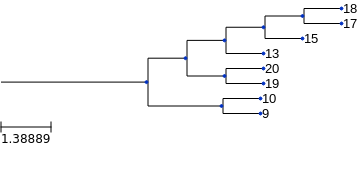

In [439]:
# Look at the real ancestry tree
t = system['log'].ancestry(prune_death=True)
t.show(inline=True)